# inverse MDS simulations to determine optimal trial size and number
## first, some imports and a bunch of function definitions

In [21]:
%config InlineBackend.figure_format='retina'

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances
from itertools import combinations, permutations
from more_itertools import random_combination
from scipy.stats import pearsonr, spearmanr
from copy import deepcopy
from random import shuffle
from joblib import Parallel, delayed
from subs2vec.vecs import Vectors

plt.rcParams['figure.figsize'] = [8, 8]
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [2]:
# print only 2 decimals
display2 = lambda x: display(x.round(2))

# generate uniform random number with 2 decimals
rand2 = lambda: np.around(np.random.uniform(), 2)

# compute root mean square of matrix
rms = lambda x: np.sqrt(np.mean(np.square(x)))

# scale matrix to a root mean square of 1
rms_scale = lambda x: x / rms(x)

# normalize vector
norm = lambda x: x / np.linalg.norm(x)

# compute cosine distance
cos = lambda a, b: np.dot(norm(a), norm(b))

# compute cosine projection
proj = lambda a, b, c: cos(c - a, b)

# generate toy data
def toy_data(n, d):
    toy_dict = {i: [rand2() for j in range(d)] for i in range(n)}
    toy_df = pd.DataFrame.from_dict(toy_dict, orient='index', columns=list(range(d)))
    return toy_df, toy_dict

# compute multi-item arrangements distances using cosine projections
def arrang_dists(arrang):
    n = len(arrang)
    dists = np.zeros((n, n))
    for i in range(n):
        if i == 0:
            a = 0
        elif i == (n - 1):
            a = 1
        else:
            a = (proj(arrang.iloc[0, :], arrang.iloc[i, :], arrang.iloc[n - 1, :]) + 1) / 2
        for j in range(n):
            if j == 0:
                b = 0
            elif j == (n - 1):
                b = 1
            else:
                b = (proj(arrang.iloc[0, :], arrang.iloc[j, :], arrang.iloc[n - 1, :]) + 1) / 2
            dists[i, j] = np.abs(a - b)
    return dists

# create multi-item arrangements from toy data
def sample_arrangs(df, arrang_size, n_arrangs):
    arrangs = [random_combination(df.index, arrang_size) for i in range(n_arrangs)]
    return {arrang: arrang_dists(df.loc[arrang, :]) for arrang in arrangs}

In [3]:
# compute inverse MDS using method 1 as described in Kriegeskorte & Mur (2012)

def inverse_mds(arrangs, n):
    arrangs = deepcopy(arrangs)
    
    # step 1: compute evidence weighted distance per pair    
    # step 2: make RDM from weighted average distances
    rdm = np.zeros((n, n))
    evidence = np.zeros((n, n))
    for idx, arrang in arrangs.items():
        for a, j in enumerate(idx):
            for b, k in enumerate(idx):
                if (a == 0) & (b == len(idx) - 1):
                    pass
                elif (b == 0) & (a == len(idx) - 1):
                    pass
                else:
                    rdm[j, k] += arrang[a, b]
                    evidence[j, k] += arrang[a, b] ** 2
                
    mean_rdm = np.nan_to_num(rdm / evidence)
    
    def iterative_scaling(scaled_arrangs, rdm, itr, prior_rmsd=1e9):
        # step 3: scale RDM to RMS of 1
        rdm = rms_scale(rdm)

        # step 4: scale arrangement pair distances to have same RMS as arrangement pairs from RDM
        for idx, arrang in scaled_arrangs.items():
            rms_arrang = rms(arrang)
            rms_rdm = rms(rdm[idx, :][:, idx])
            scaled_arrangs[idx] = arrang / (rms_arrang / rms_rdm)
        
        # step 5: create novel rdm
        prior_rdm = rdm
        rdm = np.zeros((n, n))
        for idx, arrang in arrangs.items():
            for a, j in enumerate(idx):
                for b, k in enumerate(idx):
                    if (a == 0) & (b == len(idx) - 1):
                        pass
                    elif (b == 0) & (a == len(idx) - 1):
                        pass
                    else:
                        rdm[j, k] += arrang[a, b]
                        rdm[j, k] += scaled_arrangs[idx][a, b] * (arrang[a, b] ** 2)
                    
        rdm = np.nan_to_num(rdm / evidence)
        
        # step 6: check if RMS of difference between new RDM and prior RDM is approaching 0
        # step 7: or return to step 3
        rmsd = rms(rdm - prior_rdm)
        itr += 1
        #print(f'iteration {itr}: {rmsd}')
        if prior_rmsd - rmsd > .001:
            return iterative_scaling(scaled_arrangs, rdm, itr, rmsd)
        else:
            return rdm, rmsd

    itr = 0
    scaled_arrangs = deepcopy(arrangs)
    mds_rdm, rmsd = iterative_scaling(scaled_arrangs, mean_rdm, itr)
    return mds_rdm, mean_rdm, rmsd

In [4]:
# function for computing correlation between a dataframe's RDM and an RDM recovered using inverse MDS
# for a specified trial size and number of trials

def compute_mds_corr(df, arrang_size, n_arrangs):
    t1 = time.time()
    arrangs = sample_arrangs(df, arrang_size, n_arrangs)
    mds_rdm, mean_rdm, rmsd = inverse_mds(arrangs, len(df))
    orig_rdm = pairwise_distances(df, metric='euclidean')
    t2 = time.time()
    print(f'computed inverse MDS for {n_arrangs} arrangements of size {arrang_size} in {t2 - t1:.2f}s')
    return {'mds_r': pearsonr(mds_rdm.ravel(), orig_rdm.ravel())[0],
            'mean_rdm_r': pearsonr(mean_rdm.ravel(), orig_rdm.ravel())[0],
            'size': arrang_size, 'n': n_arrangs, 'rmsd': rmsd}

In [5]:
# function for running parallellized simulations across a range of trial sizes and number of trials

def sim_mds(df, arrang_size_range, n_arrangs_range, n_jobs=6):
    t1 = time.time()
    params = []
    n = 0
    for arrang_size in arrang_size_range:
        for n_arrangs in n_arrangs_range:
            n += 1
            params.append((arrang_size, n_arrangs))
    params = list(reversed(params))
    results = Parallel(n_jobs=n_jobs)(delayed(compute_mds_corr)(df, params[i][0], params[i][1]) for i in range(n))
    sim_df = pd.DataFrame(results)
    t2 = time.time()
    print(f'computed parallel jobs in {t2 - t1:.2f}s')
    return sim_df

# simulations using toy (randomly generated) data
## simulate data and compute MDS correlations

In [14]:
sim_df = pd.concat([
    sim_mds(toy_data(50, 100)[0], range(3, 11, 1), [int(x) for x in np.logspace(2.5, 4.5, 9)]) for i in range(5)
]).groupby(['size', 'n']).mean().reset_index()

computed parallel jobs in 1576.67s
computed parallel jobs in 1585.07s
computed parallel jobs in 1550.97s
computed parallel jobs in 1539.67s
computed parallel jobs in 1537.44s


In [42]:
sim_df['concepts'] = 50
sim_df['type'] = 'random'
sim_df['n_triads'] = len(list(combinations(list(range(50)), 3)))
sim_df['log_n'] = np.log10(sim_df['n'])
display2(sim_df)
sim_df.to_csv('data/inverse_mds_50_random_concepts.tsv', sep='\t', index=False)

,size,n,mds_r,mean_rdm_r,rmsd,concepts,type,n_triads,log_n
0,3,316,0.10,0.10,0.88,50,random,19600,2.50
1,3,562,0.14,0.13,1.15,50,random,19600,2.75
2,3,1000,0.22,0.21,1.40,50,random,19600,3.00
3,3,1778,0.34,0.32,1.56,50,random,19600,3.25
4,3,3162,0.51,0.48,1.64,50,random,19600,3.50
...,...,...,...,...,...,...,...,...,...
67,10,3162,0.17,0.11,4.89,50,random,19600,3.50
68,10,5623,0.21,0.13,4.35,50,random,19600,3.75
69,10,10000,0.25,0.16,4.01,50,random,19600,4.00
70,10,17782,0.27,0.17,3.91,50,random,19600,4.25


## plot inverse mds results for toy data
### 3D surface plots of inverse MDS correlations

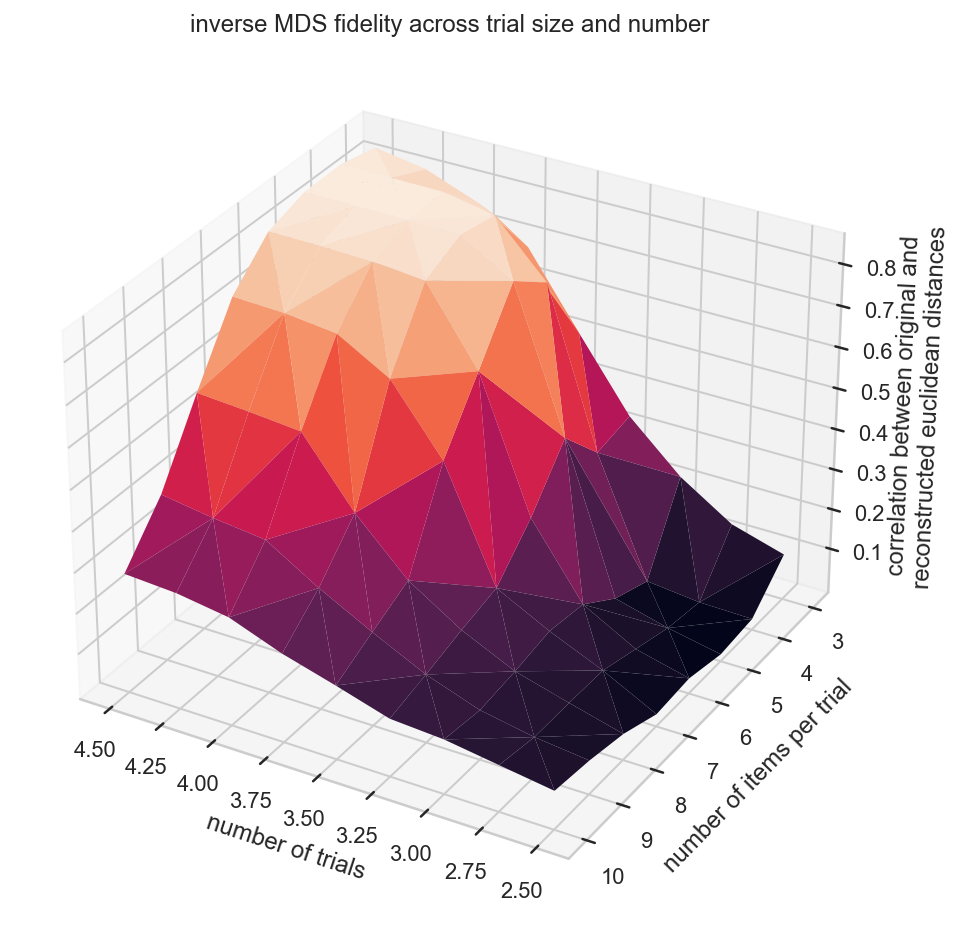

In [43]:
sns.set_style('whitegrid')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = sim_df['log_n']
y = sim_df['size']
z = sim_df['mds_r']

ax.set(xlabel='number of trials',
       ylabel='number of items per trial',
       zlabel='correlation between original and\nreconstructed euclidean distances',
       title='inverse MDS fidelity across trial size and number')

ax.plot_trisurf(x, y, z, cmap='rocket', linewidth=0)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.savefig('figures/3d_inverse_mds_corr_50_random_concepts.pdf')

In the figure above, the height and color of the surface represents how well the similarity structure (pair-wise distances), reconstructed from trials using inverse MDS, correlates with the original similarity structure.

The correlation never rises above .5 which is perhaps not surprising. What _is_ interesting is that while the correlation appears to rise with increasing number of trials (i.e. more samples) across the board, the number of items per trial appears to have an optimum around 7-8 items per trial.

In the figure below, the fidelity of an intermediate matrix from the inverse MDS procedure is plotted. This is purely based on the intuition that the weighted average RDM before further optimization might work better for smaller trials (i.e. fewer items per trial) and that intuition appears to be true!

Based on this figure, the optimal trial structure for recovering the original similarity structure appears to be 3-item (triad) trials. (And obviously more trials is better here, too.)

### intermediate (mean) RDM correlations

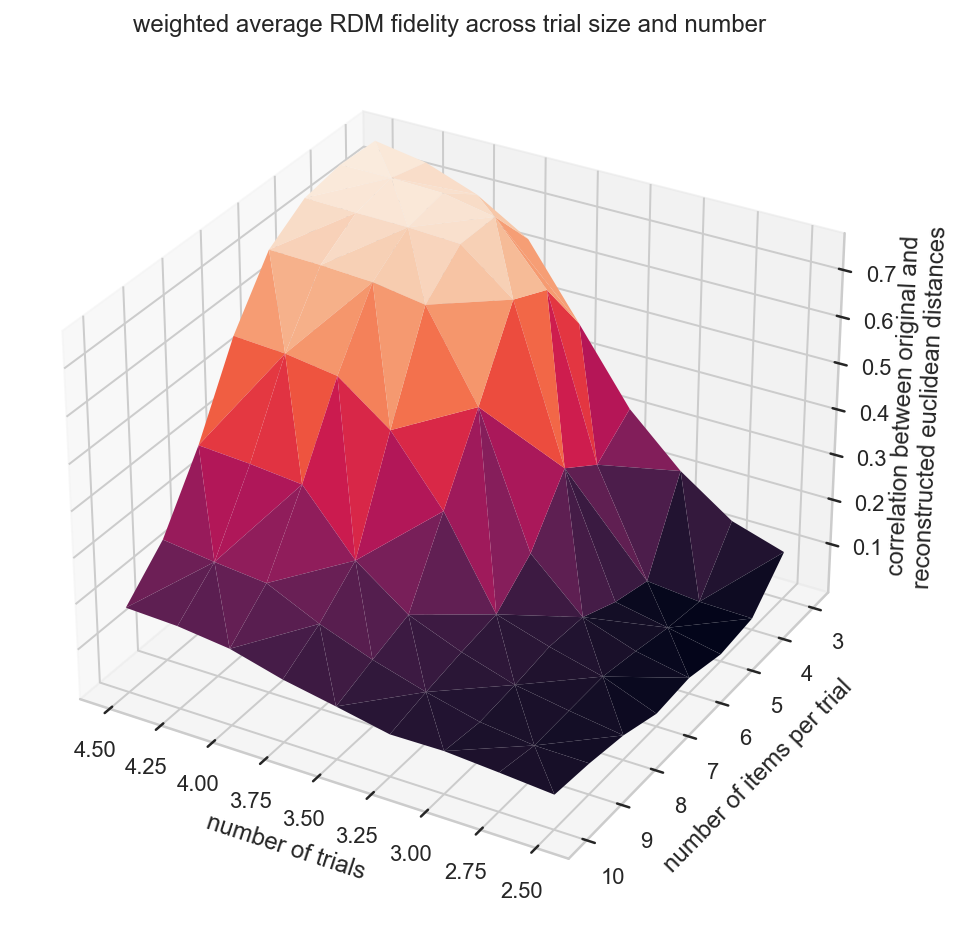

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = sim_df['log_n']
y = sim_df['size']
z = sim_df['mean_rdm_r']

ax.set(xlabel='number of trials',
       ylabel='number of items per trial',
       zlabel='correlation between original and\nreconstructed euclidean distances',
       title='weighted average RDM fidelity across trial size and number')

ax.plot_trisurf(x, y, z, cmap='rocket', linewidth=0)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.savefig('figures/3d_mean_rdm_corr_50_random_concepts.pdf')

### 2D line plots of inverse MDS correlations

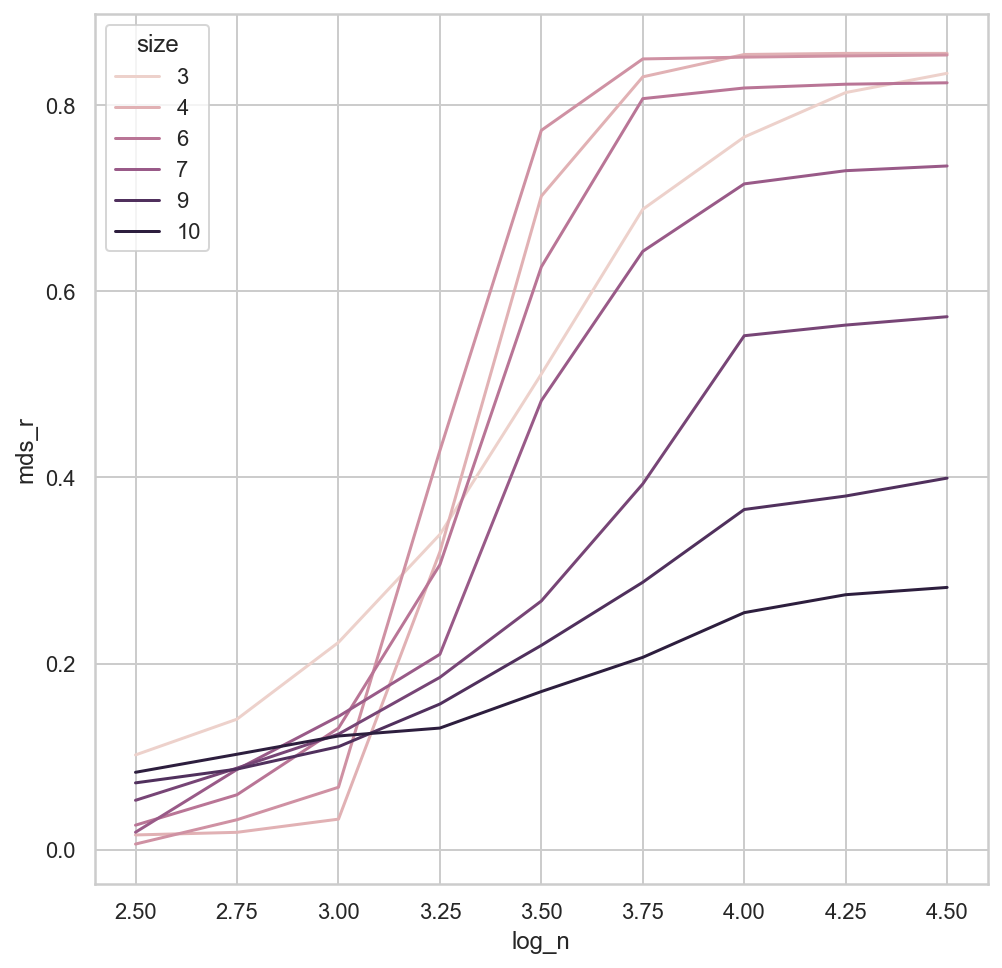

In [45]:
sns.set(style='whitegrid', palette='Set2')
ax = sns.lineplot(x='log_n', y='mds_r', hue='size', data=sim_df[sim_df['size'] < 11])
plt.savefig('figures/2d_inverse_mds_corr_50_random_concepts.pdf')

### intermediate (mean) RDM correlations

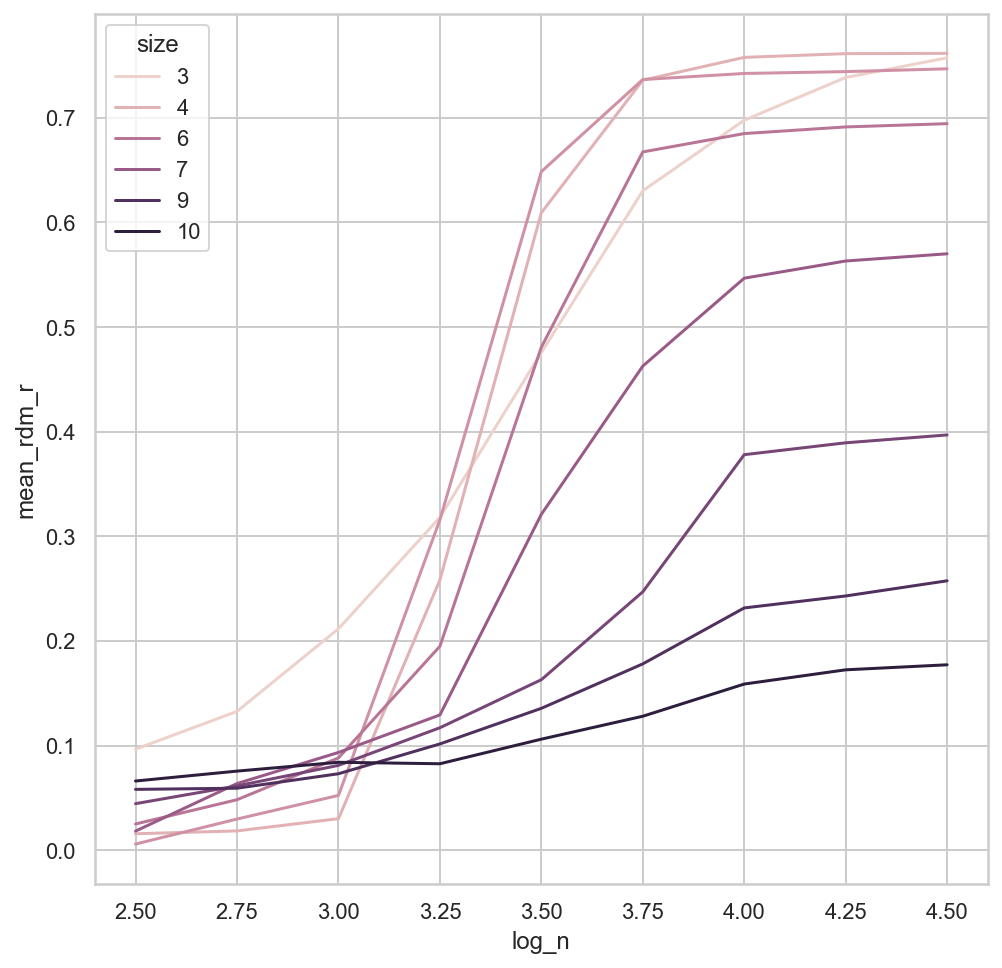

In [46]:
sns.set(style='whitegrid', palette='Set2')
ax = sns.lineplot(x='log_n', y='mean_rdm_r', hue='size', data=sim_df[sim_df['size'] < 11])
plt.savefig('figures/2d_mean_rdm_corr_50_random_concepts.pdf')

# simulations using embeddings
## simulate data and compute MDS correlations

In [29]:
vecs = Vectors('../../embeddings/cc.en.300.vec', normalize=True, n=10000)
emb_df = vecs.as_df()[5000:10000:100].reset_index().drop(columns='index')
display(emb_df.head())

[INFO] loading vectors ../../embeddings/cc.en.300.vec
[INFO] <function Vectors.__init__ at 0x13f455e50> ran in 0.299 seconds
[INFO] <function Vectors.as_df at 0x13f455f70> ran in 0.005 seconds


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.077125,0.032096,0.007886,0.069791,0.004101,-0.008123,0.078544,0.000710,0.065848,-0.002681,...,-0.048577,0.058198,-0.005441,-0.037458,0.129882,-0.056621,0.177513,0.053940,0.015535,-0.064901
1,-0.028732,0.032521,-0.045782,-0.110194,-0.047993,-0.022418,0.051781,-0.005052,-0.077356,-0.001263,...,0.020523,-0.030311,-0.075462,-0.043572,-0.000316,-0.037889,-0.020523,0.005368,-0.090618,0.047677
2,0.069535,-0.091181,0.146546,-0.020142,0.015525,-0.034164,-0.129687,-0.079807,-0.009383,0.028636,...,-0.002690,0.013577,0.019825,0.022853,0.000466,-0.004977,0.051764,0.212861,0.057737,-0.031792
3,-0.103282,0.116743,-0.003304,0.000979,-0.119680,0.098142,-0.014562,-0.076850,0.010157,-0.009790,...,0.008688,0.160430,0.072689,0.015296,-0.004038,-0.066693,0.019212,0.078196,0.053109,0.031327
4,-0.057645,-0.023630,-0.008041,-0.082092,0.078673,-0.012062,-0.073061,0.033305,-0.015911,-0.039455,...,-0.115633,0.079232,-0.012041,0.033391,0.000645,-0.005053,-0.041669,0.438925,-0.016900,0.062912


In [30]:
emb_sim_df = pd.concat([
    sim_mds(emb_df, range(3, 11, 1), [int(x) for x in np.logspace(2.5, 4.5, 9)]) for i in range(5)
]).groupby(['size', 'n']).mean().reset_index()

computed parallel jobs in 1557.66s
computed parallel jobs in 1532.29s
computed parallel jobs in 1556.20s
computed parallel jobs in 1618.70s
computed parallel jobs in 1517.12s


In [47]:
emb_sim_df['concepts'] = 50
emb_sim_df['type'] = 'random'
emb_sim_df['n_triads'] = len(list(combinations(list(range(50)), 3)))
emb_sim_df['log_n'] = np.log10(emb_sim_df['n'])
display2(emb_sim_df)
emb_sim_df.to_csv('data/inverse_mds_50_embedding_concepts.tsv', sep='\t', index=False)

,size,n,mds_r,mean_rdm_r,rmsd,concepts,type,n_triads,log_n
0,3,316,0.10,0.09,0.86,50,random,19600,2.50
1,3,562,0.15,0.14,1.15,50,random,19600,2.75
2,3,1000,0.22,0.20,1.40,50,random,19600,3.00
3,3,1778,0.35,0.32,1.57,50,random,19600,3.25
4,3,3162,0.52,0.47,1.65,50,random,19600,3.50
...,...,...,...,...,...,...,...,...,...
67,10,3162,0.24,0.15,4.30,50,random,19600,3.50
68,10,5623,0.28,0.17,4.06,50,random,19600,3.75
69,10,10000,0.30,0.19,3.95,50,random,19600,4.00
70,10,17782,0.31,0.20,3.93,50,random,19600,4.25


## plot inverse mds results for toy data
### 3D surface plots of inverse MDS correlations

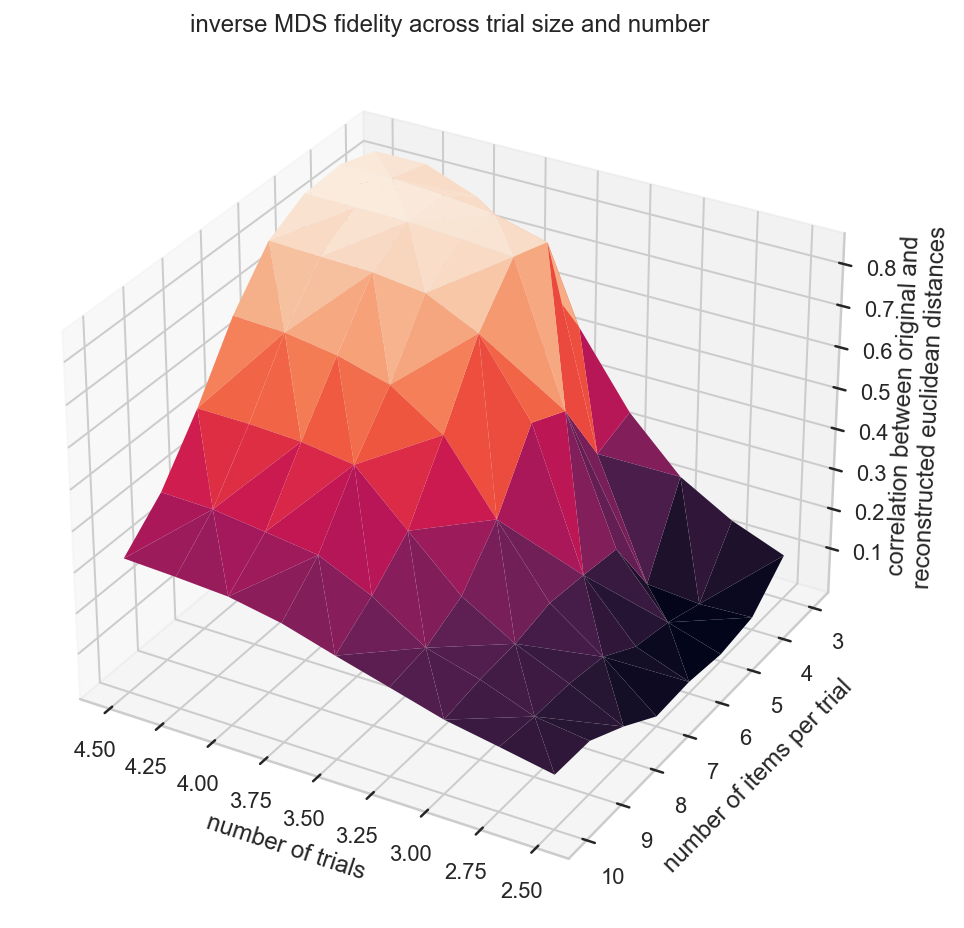

In [48]:
sns.set_style('whitegrid')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = emb_sim_df['log_n']
y = emb_sim_df['size']
z = emb_sim_df['mds_r']

ax.set(xlabel='number of trials',
       ylabel='number of items per trial',
       zlabel='correlation between original and\nreconstructed euclidean distances',
       title='inverse MDS fidelity across trial size and number')

ax.plot_trisurf(x, y, z, cmap='rocket', linewidth=0)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.savefig('figures/3d_inverse_mds_corr_50_embedding_concepts.pdf')

In the figure above, the height and color of the surface represents how well the similarity structure (pair-wise distances), reconstructed from trials using inverse MDS, correlates with the original similarity structure.

The correlation never rises above .5 which is perhaps not surprising. What _is_ interesting is that while the correlation appears to rise with increasing number of trials (i.e. more samples) across the board, the number of items per trial appears to have an optimum around 7-8 items per trial.

In the figure below, the fidelity of an intermediate matrix from the inverse MDS procedure is plotted. This is purely based on the intuition that the weighted average RDM before further optimization might work better for smaller trials (i.e. fewer items per trial) and that intuition appears to be true!

Based on this figure, the optimal trial structure for recovering the original similarity structure appears to be 3-item (triad) trials. (And obviously more trials is better here, too.)

### intermediate (mean) RDM correlations

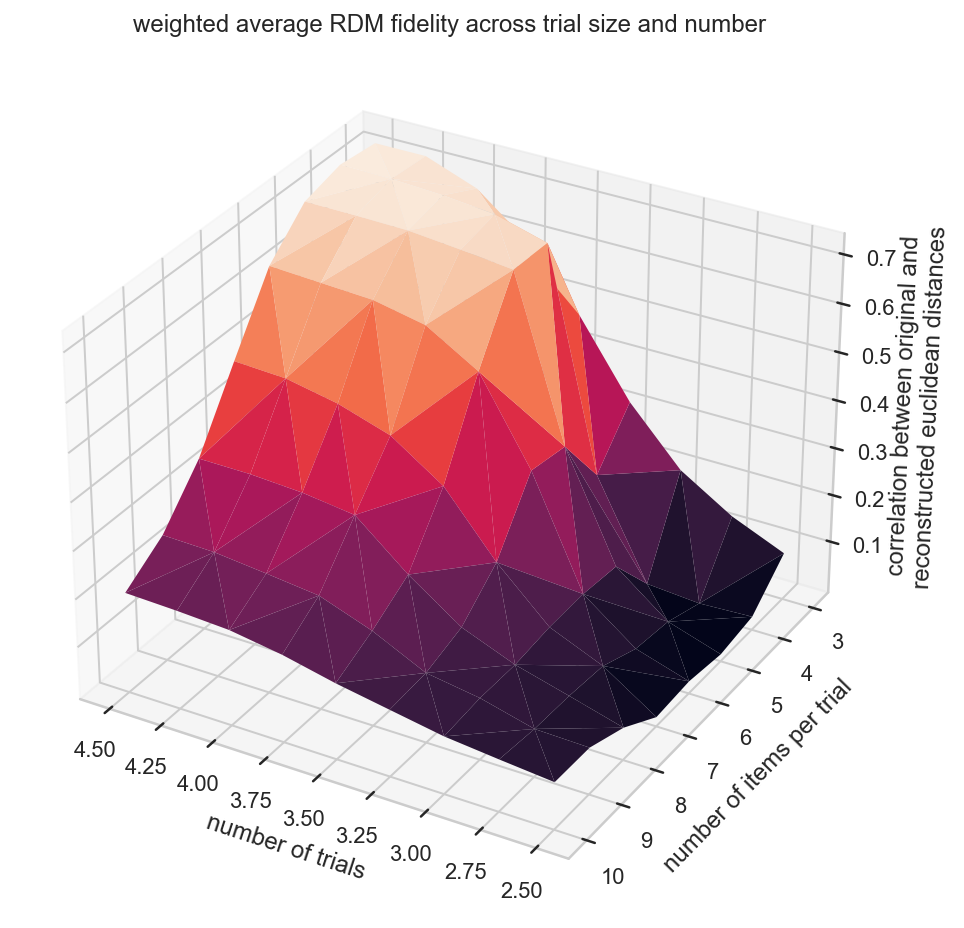

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = emb_sim_df['log_n']
y = emb_sim_df['size']
z = emb_sim_df['mean_rdm_r']

ax.set(xlabel='number of trials',
       ylabel='number of items per trial',
       zlabel='correlation between original and\nreconstructed euclidean distances',
       title='weighted average RDM fidelity across trial size and number')

ax.plot_trisurf(x, y, z, cmap='rocket', linewidth=0)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.savefig('figures/3d_mean_rdm_corr_50_embedding_concepts.pdf')

### 2D line plots of inverse MDS correlations

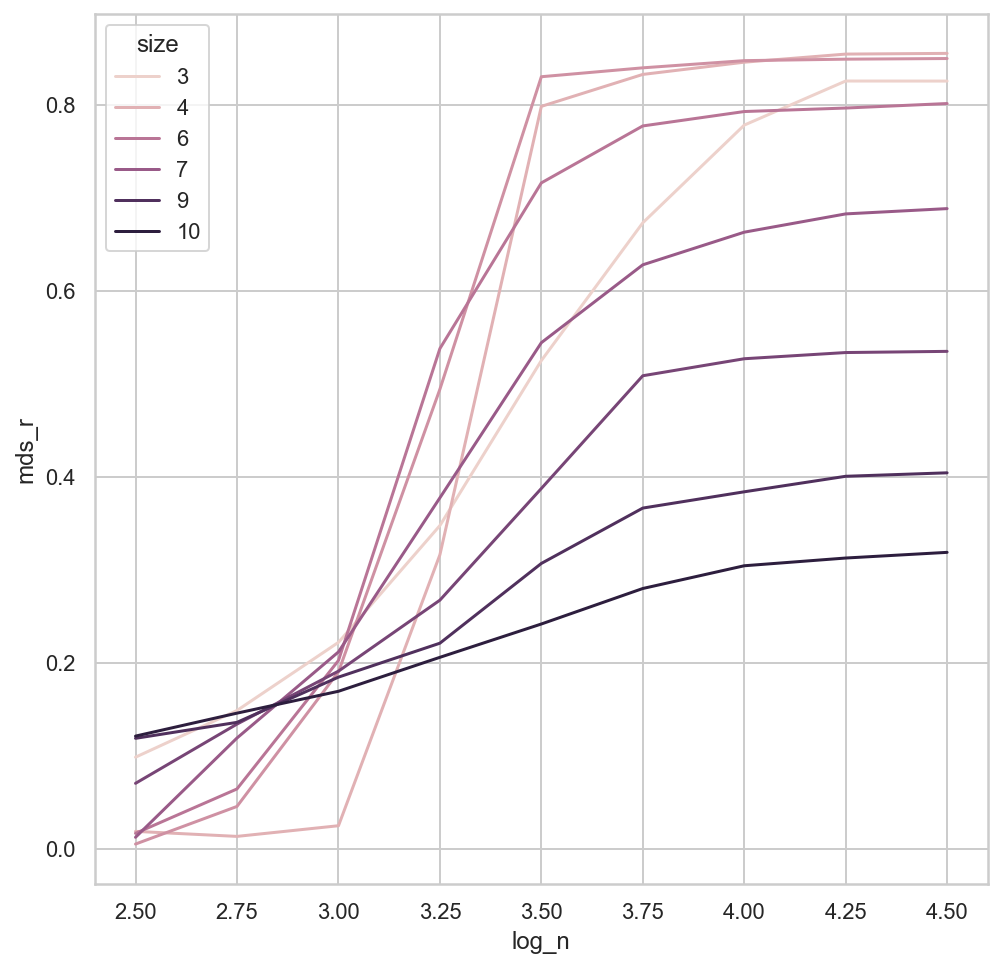

In [50]:
sns.set(style='whitegrid', palette='Set2')
ax = sns.lineplot(x='log_n', y='mds_r', hue='size', data=emb_sim_df[emb_sim_df['size'] < 11])
plt.savefig('figures/2d_inverse_mds_corr_50_embedding_concepts.pdf')

### intermediate (mean) RDM correlations

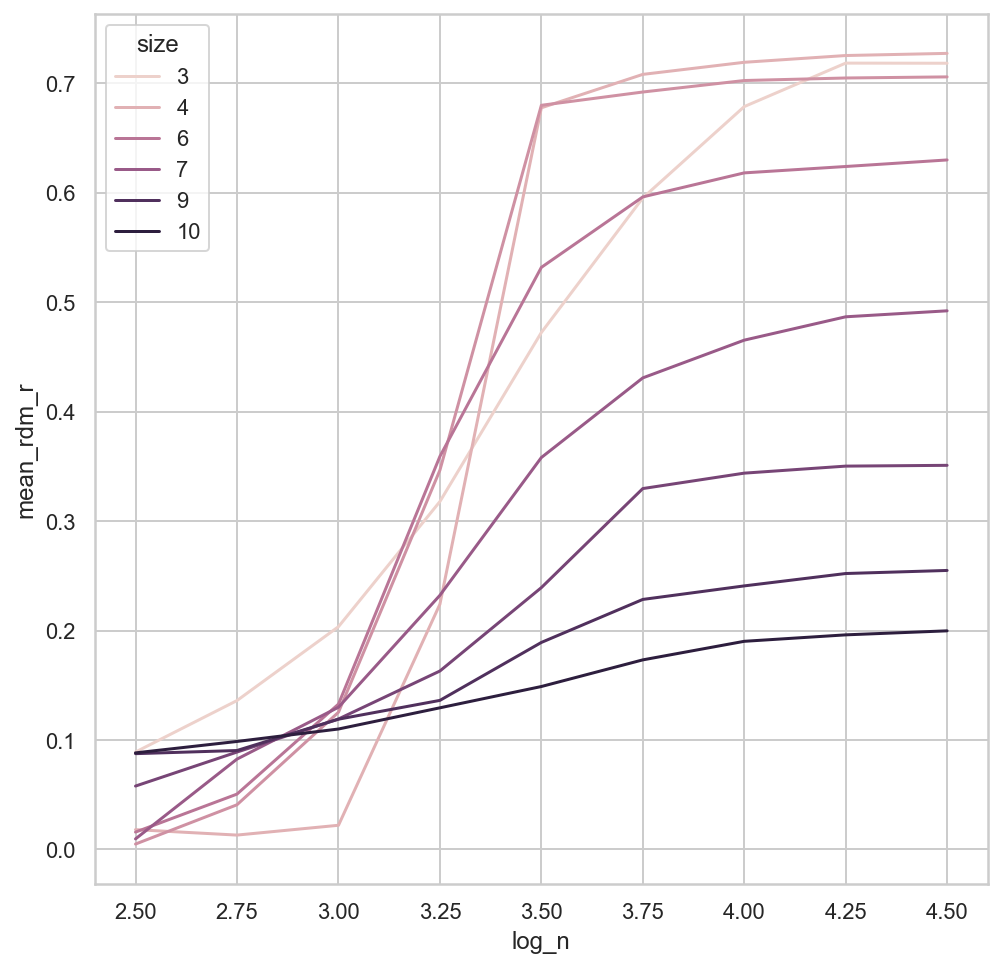

In [51]:
sns.set(style='whitegrid', palette='Set2')
ax = sns.lineplot(x='log_n', y='mean_rdm_r', hue='size', data=emb_sim_df[emb_sim_df['size'] < 11])
plt.savefig('figures/2d_mean_rdm_corr_50_embedding_concepts.pdf')